# Exploratory Data Analysis & Feature Engineering  
## Predictive Analytics System for Financial Risk Assessment

### Objective

The goal of this analysis is to explore and prepare a consumer credit dataset for
predicting the probability of default. The task is framed as a binary classification
problem where the target variable indicates whether a customer defaults on their
credit card payment in the next month.

This notebook focuses on:
- Understanding data quality and distributions
- Identifying key risk-driving variables
- Engineering business-relevant features
- Producing a clean, model-ready dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

### Data Loading and Initial Cleanup

The dataset is sourced from the UCI Machine Learning Repository and contains
demographic, credit limit, billing, payment, and repayment status information
for 30,000 credit card clients.

The following preprocessing steps are applied:
- Rename the target variable for clarity
- Remove identifier columns
- Perform a basic structural sanity check

In [2]:
# Load data
df = pd.read_csv(
    r"D:\Data Science\financial-risk-predictive-analytics\UCI_Credit_Card.csv"
)

# Standardize target name
df = df.rename(columns={"default.payment.next.month": "default"})

# Drop non-informative ID column
df = df.drop(columns=["ID"], errors="ignore")

print("Shape:", df.shape)
df.head()

Shape: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Data Quality Assessment

Before any modeling, it is critical to verify:
- Presence of missing values
- Validity of categorical codes
- Overall data consistency

In [3]:
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

**Observation:**  
No missing values are present in the dataset, which simplifies preprocessing
and ensures no imputation bias is introduced.

### Target Variable Distribution

The target variable (`default`) indicates whether a customer defaulted on their
next payment.

Understanding class balance is essential for selecting appropriate evaluation
metrics and modeling strategies.

In [4]:
target_counts = df["default"].value_counts().sort_index()
target_pct = df["default"].value_counts(normalize=True).sort_index() * 100

pd.DataFrame({
    "count": target_counts,
    "percentage": target_pct.round(2)
})

,count,percentage
default,,
0,23364,77.88
1,6636,22.12


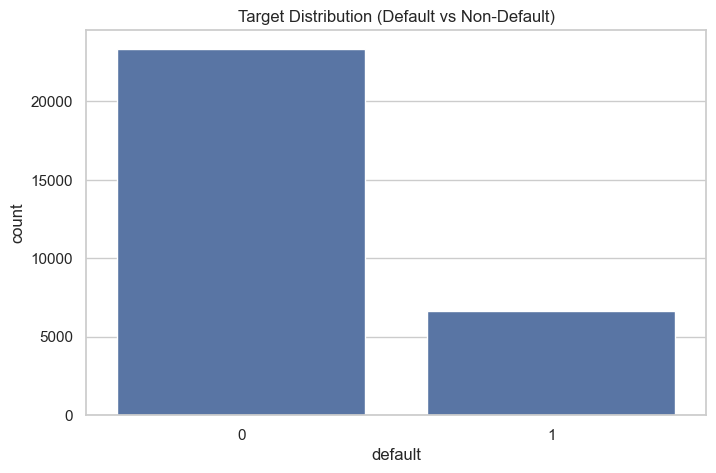

In [5]:
sns.countplot(x="default", data=df)
plt.title("Target Distribution (Default vs Non-Default)")
plt.show()

**Key Insight:**
- Default rate ≈ 22%
- Moderate class imbalance reflects real-world credit portfolios
- ROC-AUC and Precision-Recall metrics are more appropriate than accuracy

### Categorical Variable Validation

Certain categorical variables contain undocumented or invalid codes.
These are consolidated into an "Other / Unknown" category to improve stability.

In [6]:
# EDUCATION: consolidate undocumented categories
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})

# MARRIAGE: fix undocumented value
df["MARRIAGE"] = df["MARRIAGE"].replace({0: 3})

df[["EDUCATION", "MARRIAGE"]].apply(pd.Series.value_counts)

,EDUCATION,MARRIAGE
1,10585,13659.0
2,14030,15964.0
3,4917,377.0
4,468,NaN


### Distribution of Key Numeric Features

Financial variables typically exhibit skewness and heavy tails.
Understanding their distribution helps guide transformations and model choice.

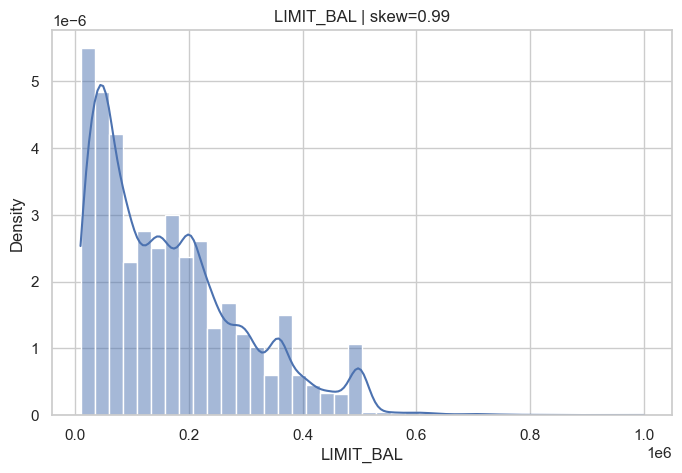

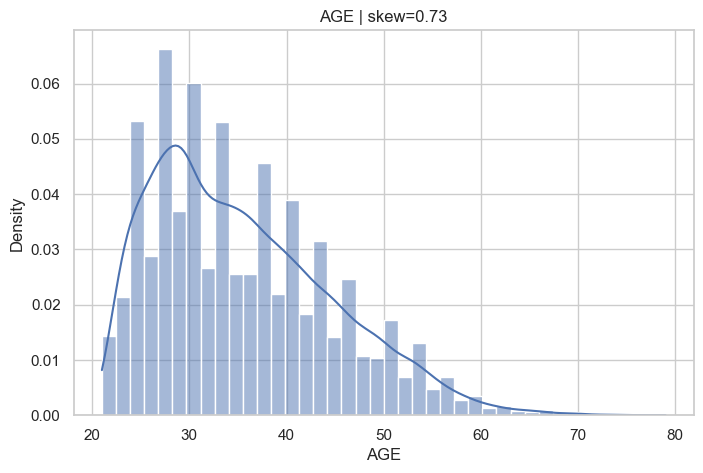

In [7]:
numeric_cols = df.select_dtypes(include=np.number).columns.drop("default")

def plot_distribution(col):
    sns.histplot(df[col], bins=40, kde=True, stat="density")
    plt.title(f"{col} | skew={df[col].skew():.2f}")
    plt.show()

for col in ["LIMIT_BAL", "AGE"]:
    plot_distribution(col)

**Observations:**
- Credit limits and billing amounts are right-skewed
- Age shows mild skew and no abnormal values
- Tree-based models will naturally handle skewness

### Payment Delinquency Behavior

Repayment status variables (`PAY_0`–`PAY_6`) capture historical delinquency.
They are among the strongest predictors of default.

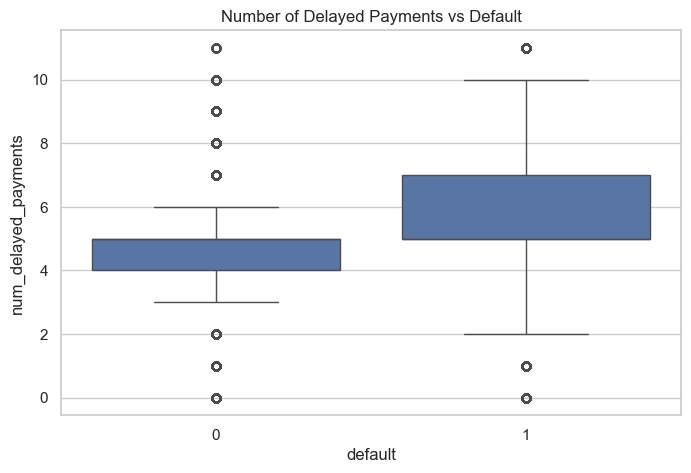

In [8]:
pay_cols = [c for c in df.columns if c.startswith("PAY_") and c != "PAY_AMT1"]

df["num_delayed_payments"] = (df[pay_cols] > 0).sum(axis=1)
df["ever_late"] = (df[pay_cols] > 0).any(axis=1).astype(int)

sns.boxplot(x="default", y="num_delayed_payments", data=df)
plt.title("Number of Delayed Payments vs Default")
plt.show()

**Insight:**  
Customers with a history of delayed payments show a dramatically higher
likelihood of default. This feature is expected to be highly influential.

### Billing and Payment Aggregates

Aggregated financial behavior often provides more robust signals than
individual monthly values.

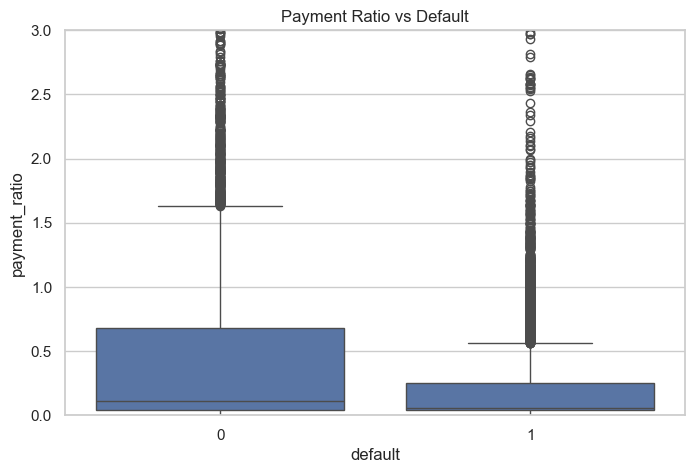

In [9]:
bill_cols = [c for c in df.columns if c.startswith("BILL_AMT")]
pay_amt_cols = [c for c in df.columns if c.startswith("PAY_AMT")]

df["total_bill_amt"] = df[bill_cols].sum(axis=1)
df["total_pay_amt"] = df[pay_amt_cols].sum(axis=1)

df["payment_ratio"] = df["total_pay_amt"] / (df["total_bill_amt"] + 1)
df["credit_utilization"] = df["total_bill_amt"] / (df["LIMIT_BAL"] + 1)

sns.boxplot(x="default", y="payment_ratio", data=df)
plt.ylim(0,3)
plt.title("Payment Ratio vs Default")
plt.show()

### Recent Behavior Emphasis

Recent months are more predictive than older history.

In [10]:
df["recent_bill_mean"] = df[["BILL_AMT1","BILL_AMT2","BILL_AMT3"]].mean(axis=1)
df["recent_pay_mean"] = df[["PAY_AMT1","PAY_AMT2","PAY_AMT3"]].mean(axis=1)

### Correlation Analysis

Highly correlated variables may affect linear models but are acceptable
for tree-based models.

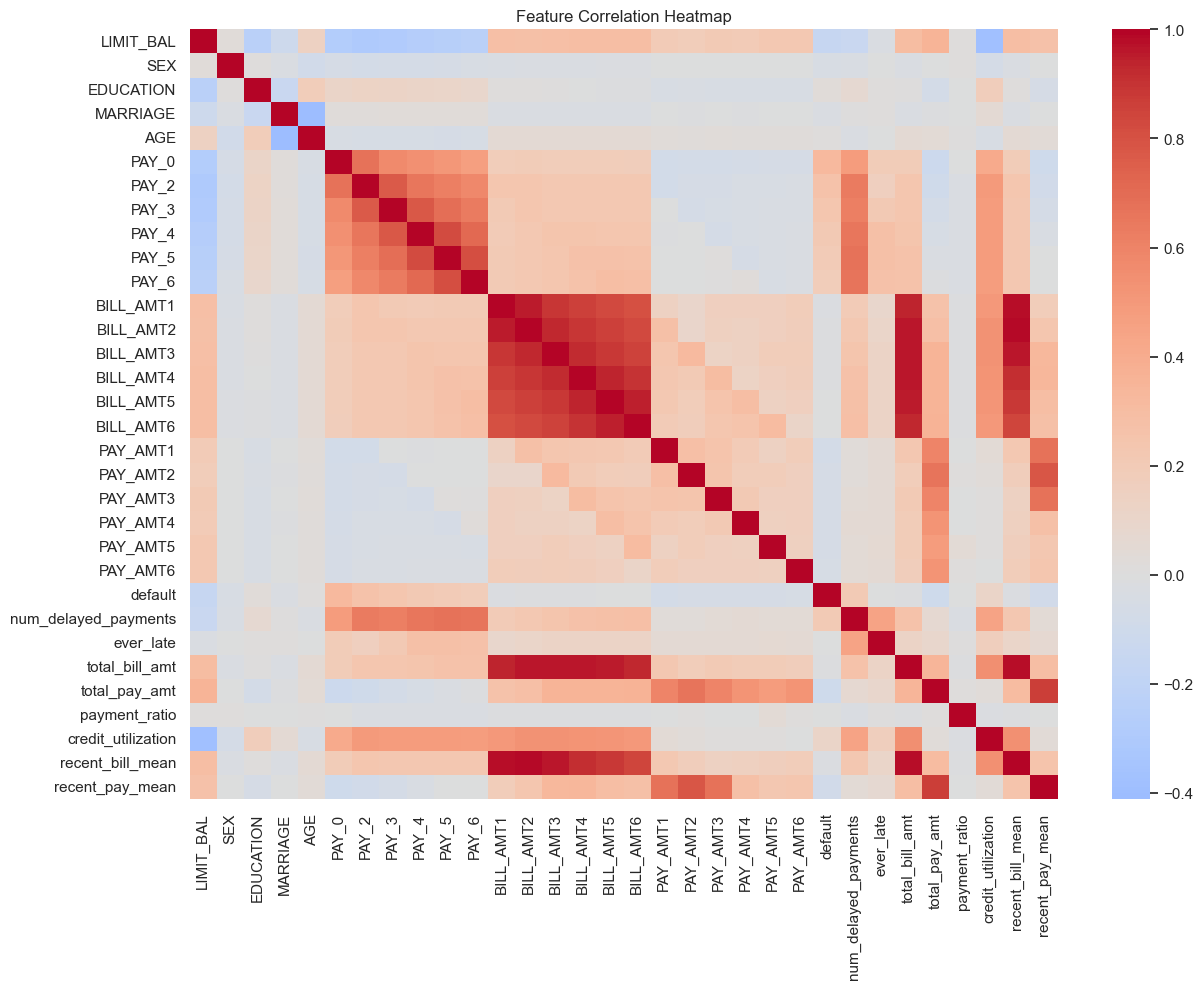

In [11]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

**Conclusion:**
- Strong correlation among monthly billing variables is expected
- No evidence of target leakage

### Feature Relevance Estimation

We estimate feature relevance using:
- Point-biserial correlation (linear relationship)
- Mutual information (non-linear dependency)

In [12]:
# Point-biserial correlation
pb = {
    col: stats.pointbiserialr(df["default"], df[col]).correlation
    for col in df.select_dtypes(include=np.number).columns
    if col != "default"
}
pb = pd.Series(pb).sort_values(key=lambda x: x.abs(), ascending=False)

# Mutual Information
df_mi = df.copy()
for c in df_mi.select_dtypes(include=["object","category"]).columns:
    df_mi[c] = LabelEncoder().fit_transform(df_mi[c].astype(str))

mi = mutual_info_classif(
    df_mi.drop(columns=["default"]),
    df_mi["default"],
    random_state=42
)
mi = pd.Series(mi, index=df_mi.drop(columns=["default"]).columns)\
       .sort_values(ascending=False)

mi.head(15)

PAY_0                   0.072094
num_delayed_payments    0.063887
PAY_2                   0.048487
PAY_3                   0.038640
PAY_5                   0.031352
PAY_4                   0.030734
PAY_6                   0.027939
total_pay_amt           0.024374
PAY_AMT1                0.023977
recent_pay_mean         0.020914
PAY_AMT3                0.017976
credit_utilization      0.016394
PAY_AMT4                0.016143
payment_ratio           0.015978
LIMIT_BAL               0.015759
dtype: float64

**Key Drivers Identified:**
- Repayment status (`PAY_*`)
- Delinquency counts
- Credit utilization
- Payment ratios

### Final Dataset Preparation — Selected Minimal Features

We prepare a compact, deployable feature set (kept intentionally small for API use and auditability).
Selected features were chosen because they are:
- **Predictive** (high mutual information / importance in tree models)
- **Easy to compute** from client-provided values
- **Interpretable** and stable across populations

**Final feature list (kept for modeling / deployment):**
- LIMIT_BAL
- total_bill_amt (or recent_bill_mean if you prefer last 3 months)
- total_pay_amt (or recent_pay_mean)
- payment_ratio = total_pay_amt / (total_bill_amt + 1)
- credit_utilization = total_bill_amt / (LIMIT_BAL + 1)
- num_delayed_payments (count of PAY_* > 0)
- ever_late (flag)
- AGE
- SEX (category)
- EDUCATION (category)
- MARRIAGE (category)
- recent_bill_mean (optional but kept here for extra signal)

The next cell builds `final_df` using the list above and performs minimal, conservative imputation and dtype normalization. This `final_df` will be the direct input to model training and to the deployment pipeline.

In [13]:
# Build a compact final_df with selected features for modeling
selected_features = [
    'LIMIT_BAL', 'total_bill_amt', 'total_pay_amt', 'payment_ratio',
    'credit_utilization', 'num_delayed_payments', 'ever_late',
    'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'recent_bill_mean'
]

# Keep only features that exist in the dataset (warn if any are missing)
final_features = [f for f in selected_features if f in df.columns]
missing = set(selected_features) - set(final_features)
if missing:
    print('Warning: the following expected features are missing and will be excluded:', missing)

# Create final_df and perform minimal imputation and dtype normalization
final_df = df[final_features].copy()

# Numeric imputation (median) and categorical fill (mode)
num_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = final_df.select_dtypes(include=['object','category']).columns.tolist()

for c in num_cols:
    final_df[c] = final_df[c].fillna(final_df[c].median())
for c in cat_cols:
    if final_df[c].isnull().any():
        final_df[c] = final_df[c].fillna(final_df[c].mode().iloc[0])

# Ensure categories use 'category' dtype and keep small cardinality
for c in ['SEX','EDUCATION','MARRIAGE']:
    if c in final_df.columns:
        final_df[c] = final_df[c].astype('category')

print('final_df shape:', final_df.shape)
print('features kept:', final_df.columns.tolist())

# Quick checks
print('\nMissing values per column in final_df:')
display(final_df.isnull().sum())

print('\nPreview:')
display(final_df.head())

# Assign X and y for later modeling
X = final_df
y = df['default']

print('\nX shape:', X.shape)
print('Target distribution:')
display(y.value_counts(normalize=True))

# (Optional) Save final df to disk for reproducibility (uncomment to use)
# final_df.to_csv(r"D:\Data Science\financial-risk-predictive-analytics\data\final_df.csv", index=False)


final_df shape: (30000, 12)
features kept: ['LIMIT_BAL', 'total_bill_amt', 'total_pay_amt', 'payment_ratio', 'credit_utilization', 'num_delayed_payments', 'ever_late', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'recent_bill_mean']

Missing values per column in final_df:


LIMIT_BAL               0
total_bill_amt          0
total_pay_amt           0
payment_ratio           0
credit_utilization      0
num_delayed_payments    0
ever_late               0
AGE                     0
SEX                     0
EDUCATION               0
MARRIAGE                0
recent_bill_mean        0
dtype: int64


Preview:


,LIMIT_BAL,total_bill_amt,total_pay_amt,payment_ratio,credit_utilization,num_delayed_payments,ever_late,AGE,SEX,EDUCATION,MARRIAGE,recent_bill_mean
0,20000.0,7704.0,689.0,0.089422,0.385181,3,1,24,2,2,1,2568.000000
1,120000.0,17077.0,5000.0,0.292774,0.142307,6,1,26,2,2,2,2363.000000
2,90000.0,101653.0,11018.0,0.108387,1.129465,5,1,34,2,2,2,18941.666667
3,50000.0,231334.0,8388.0,0.036259,4.626587,5,1,37,2,2,1,48171.333333
4,50000.0,109339.0,59049.0,0.540049,2.186736,5,1,57,1,2,1,16707.333333



X shape: (30000, 12)
Target distribution:


default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

### API Input Schema & Next Steps (compact)

**Server-side computation recommendation:** accept a compact JSON with the following raw fields (compute derived features in the API):
- LIMIT_BAL (numeric)
- BILL_AMT1, BILL_AMT2, BILL_AMT3 (or upto BILL_AMT6 if available)
- PAY_AMT1, PAY_AMT2, PAY_AMT3 (or upto PAY_AMT6)
- PAY status fields (PAY_0..PAY_6) or a pre-computed num_delayed_payments/ever_late
- AGE, SEX, EDUCATION, MARRIAGE

From these raw inputs the server computes: total_bill_amt, total_pay_amt, payment_ratio, credit_utilization, num_delayed_payments, ever_late, recent_bill_mean and returns the model score. This keeps the client payload small and ensures we compute consistent features server-side.

Next steps (when you're ready):
- Train compact models on `X, y` using Stratified K-Fold CV
- Compare a regularized Logistic Regression (L1) vs LightGBM on these features
- Use SHAP to validate behavior and test for leakage
- Select the smallest model that meets business AUC/PR-AUC requirements for deployment

## Model training, hyperparameter tuning, and evaluation
### We will:
 - Split data (stratified)
 - Create preprocessing + model pipelines
 - Use RandomizedSearchCV (ROC-AUC) for hyperparameter tuning
 - Evaluate on a hold-out test set using ROC-AUC and PR-AUC
 - Plot ROC, PR and calibration curves

In [14]:
# %% 
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, brier_score_loss
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from scipy.stats import randint, uniform

sns.set(style="whitegrid")
RND = 42
os.makedirs("models", exist_ok=True)

In [15]:
# %% 
# If you didn't already build X, y in previous cells, uncomment and create them:
# (But your notebook already created final_df -> X and y)
# X = final_df.copy()
# y = df['default'].copy()

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))

X shape: (30000, 12)
y distribution:
 default
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [16]:
# %% 
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (24000, 12) Test: (6000, 12)


In [42]:
# %% 
# Preprocessing: numeric and categorical pipelines
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['category','object']).columns.tolist()

# Remove target-ish (shouldn't be present) and ensure we don't include y
numeric_features = [c for c in numeric_features if c in X.columns]
cat_features = [c for c in cat_features if c in X.columns]

print("Numeric features:", len(numeric_features))
print("Categorical features:", cat_features)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", cat_transformer, cat_features)
], remainder="drop")

Numeric features: 31
Categorical features: []


In [43]:
# %% 
# Define model pipelines
logreg_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(solver="saga", max_iter=5000, random_state=RND))
])

rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_jobs=-1, random_state=RND))
])

lgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", lgb.LGBMClassifier(random_state=RND, n_jobs=-1))
])


In [44]:
# %% 
# Parameter distributions for RandomizedSearchCV (light but meaningful)
n_iter = 40
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

param_dist = {
    "logreg": {
        "clf__penalty": ["l2", "l1"],
        "clf__C": uniform(loc=0.01, scale=10.0),  # sampled
        "clf__class_weight": [None, "balanced"]
    },
    "rf": {
        "clf__n_estimators": randint(100, 800),
        "clf__max_depth": [None, 5, 10, 20, 40],
        "clf__min_samples_split": randint(2, 10),
        "clf__max_features": ["sqrt", "log2", 0.2, 0.5, None],
        "clf__class_weight": [None, "balanced", "balanced_subsample"]
    },
    "lgb": {
        "clf__n_estimators": randint(100, 800),
        "clf__num_leaves": randint(16, 200),
        "clf__learning_rate": uniform(loc=0.01, scale=0.3),
        "clf__max_depth": [-1, 3, 6, 12],
        "clf__subsample": uniform(loc=0.6, scale=0.4),
        # For LightGBM, use class_weight or scale_pos_weight; we'll set scale_pos_weight below
    }
}

In [45]:
# %% 
# Helper to run RandomizedSearchCV and return best estimator + cv results
def tune_model(pipe, params, X, y, cv, n_iter=40, scoring="roc_auc"):
    rs = RandomizedSearchCV(
        pipe, params, n_iter=n_iter, cv=cv, scoring=scoring,
        random_state=RND, n_jobs=-1, verbose=1, return_train_score=False
    )
    rs.fit(X, y)
    print("Best score (cv):", rs.best_score_)
    print("Best params:", rs.best_params_)
    return rs

In [46]:
# %% 
# 1) Tune Logistic Regression (fast)
print("Tuning Logistic Regression...")
rs_log = tune_model(logreg_pipe, param_dist["logreg"], X_train, y_train, cv=cv, n_iter=30)
best_log = rs_log.best_estimator_

# Save
joblib.dump(best_log, "models/logreg_pipeline.joblib")

Tuning Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Best score (cv): 0.7255849117038891
Best params: {'clf__C': np.float64(6.021150117432088), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}


['models/logreg_pipeline.joblib']

In [47]:
# %% 
# 2) Tune Random Forest
print("Tuning Random Forest...")
rs_rf = tune_model(rf_pipe, param_dist["rf"], X_train, y_train, cv=cv, n_iter=40)
best_rf = rs_rf.best_estimator_

joblib.dump(best_rf, "models/rf_pipeline.joblib")

Tuning Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 